# Scan Path Analysis
#### @tutor: Ms SHARAFI Zohreh
#### @student: Mr SHAW Oscar

### The purpose of this notebook is to analyze and compare problem solving strategies between different participants thanks to the similarity between their scanpaths

#### How do we proceed: 
First, we start the analysis by focusing only on the sequence of entities seen by the participant and measure the distance between two sequences using the Levenshtein distance.
In this perspective, we will start by cleaning & transforming the data in order to apply Levenshtein's algorithm which returns the distance between two strings.
Then, we measure the distance between two sequences thanks to the Damerau-Levenshtein algorithm, the advantage of this method is that it takes into account the transposition of two adjacent characters, so it is more tolerant to small permutations of sequences.
(for example smith -> smiht has a distance of 1 with Damerau-Levenshtein instead of 2 with Levenshtein)

A first guess would be that two people with a strong background in software engineering should know the best problem solving methods and therefore have similar sequences, i.e. a high score. Conversely, junior software engineers may have more irregular sequences.

In [2]:
# import libraries
# !pip install pandas

import os
import pandas as pd

## 1- Data Import

In [3]:
# Path of the folder which contains the files
FOLDER_PATH = "C:\\Users\\....."
DATA_FOLDER = os.path.join(FOLDER_PATH, 'data_files')

# Dictionary establishing the correspondence between a file and its sequence of entities
# i.e data{key = file_id, value = [seq. of entities]} where entities are in [‘Comment’, ‘Bug_Report’, ‘Member_Variable’, 
# ‘Method_Body’, ‘Method_Signature’]
# ex: file_id = P_103 & value = ['Comment','Bug_Report','None','Bug_Report']
data = {}


# For each csv file, we use the dataframe to populate the dictionary with the data 
for filename in os.listdir(DATA_FOLDER):
    df = pd.read_csv(os.path.join(DATA_FOLDER, filename),delimiter=',')
    data[filename.split('_')[0]] = df

## 2- Cleaning & Preprocessing

In [4]:
# clean dataframe from NONE feature values
def clean(df: object, features: [str]) -> object:
#     input:  df, features  -> object (dataframe), array of string containing the feature we want to filter 
#     output: df -> object (dataframe)   
    for i in features:
        indexNames = df[ df[i] == 'NONE' ].index
        df.drop(indexNames , inplace=True)
    df.reset_index(drop=True, inplace=True)
    return df

In [5]:
# Allow to only keep the features we want to use in our study
def selection(df: object, features: [str]) -> object:
#     input:  df, features  -> object (dataframe), array of string containing the feature we want to keep 
#     output: df -> object (dataframe)
    return df[features]

In [6]:
# Allow to convert entity name to letter for latter treatments 
def convert(df):
#     input: df -> object (dataframe) with sequence of entities in plain text
#     output: df -> object (dataframe) with sequence of letter to embodies entities
    return df.applymap(lambda x: 'A' if x.lower() == 'method_body' else ('B' if x.lower() == 'comment' else ('C' if x.lower() == 'member_variable' else ('D' if x.lower() == 'bug_report' else ('E' if x.lower() == 'method_signature' else pd.NA)))))

In [9]:
# Transform the sequence of letter into a string for latter treatments
def SequenceToString(df):
#     input: df -> object (dataframe)
#     output: string -> string which embodies the sequence of entities with letters
    return ''.join( ''.join(map(str, x)) for x in df.entity)

In [10]:
# Iterate over each dataframes and clean data in each, then convert the data.
# There we use another dictionnary for more reusability of past data
def pipeline(data,features):
#      input: data, features  -> dictionnary{key = file_id, value = object (dataframe)}, array of string containing the feature we want to keep
#      output: new_data -> dictionnary{key = file_id, value = [sequency]}   
    new_data = {}
    for i in data:
        new_data[i] = selection(data[i],features)    
        new_data[i] = convert(new_data[i])
        
        # Clean dataframe from NA values
        new_data[i].dropna(inplace=True)
        new_data[i].reset_index(drop=True, inplace=True)
        
        new_data[i] = SequenceToString(new_data[i])
    return new_data

new_data = pipeline(data,['entity'])
new_data

{'P102': 'BDBCCBDDBCBBBABEBAAAAAAAAAAAAAAAABBBAAABAAABBABBBABBABAAABABBBBAABBBABBBACCBABAAAAAAAAAAAABAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAABBAAAAAABABAABBBAAABAAEAEAAAAAAEABBAAAAAACAAAAAABBBBBCBAABBBCCBCBCCCCAAAAAABAABBBBBAAABAAAAAAAAAAAAAACAAAAAABAAAABAABABBAAAAABAABBABAAAAAAAAABAAAAAABAAAAABAAAAAAAAAABAAAAAAABBAAAAAAAAAAABAABAABAAAAAAABABABBABBABABBAAABAAAAABABAAAAAAAAAAAAAAAAAAAAAABABAAAAAAAAAAAAAAAAAAAABABBBAAAAABAAAAAAAABBABBBBABAABAAAABAACAAABBAAAAAAAAAABEBBEEAAAABEAAEAAAAAAAAAAABAABABAAAAAABAAAAAAAAAABAAAAAABABAAAAABAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAABBAABBCCAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAABABBBBBAAAAAAAAABAAAAAAABCAABAAAAAAAAAAEAAAAAAAAAAAAAAABAAAAABBAAAAAAAAAAAAAAAAAAAABAAAAAAABBABBEAACAAAABABBAABAAABCBBBBCBCCBBAAAAABAAAAABBABBBAAAAABABBBABACBAAAAABBAABAAAAAAAAAAABAABAAAAAAAAAAAAAAAAAAABAAAAAAAAAAAAAAAAAAAABAAAAAAAAAABBBAAAAAAEABAAAAAAAABBAAABABBBAAAABEAAAAABBEAABBBAEABBABAAAEAAAAAAAAAAAAAAABAAAABBBAAAAAABBAABAAAABABABAAABAAAAABAAABAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAA

In [14]:
## Just to know the average length of our sequences
import numpy as np
np.array([len(x[1]) for x in new_data.items()]).mean()

1012.0

### Recursive version of Levenshtein algorithm

In [17]:
## Recursive version of Levenshetin algorithm which return the distance between two strings
def recLevenshtein(s1: str,s2: str) -> int:
#      input: s1, s2  -> str, str: the two strings that are compared 
#      output: distance -> int: distance between the strings
    
    # We focus on the first element and then use recursivity on the tail (array without first element)
    
    if len(s1) == 0: # if s1 is empty the minimal distance is len(s2)
        return len(s2)
    elif len(s2)==0: # if s2 is empty the minimal distance is len(s1)
        return len(s1)
    elif s1[0] == s2[0]: # s1[0] == s2[0] so the distance between the strings is equal to the one between the tails
        return recLevenshtein(s1[1:],s2[1:])
    else: # s1[0] != s2[0] so the distance between the strings is equal to 1 + min(dist(tails))
        #      1 + min( lev(tail(a),tail(b)),     lev(a,tail(b)),          lev(tail(a),b)
        return 1+min(recLevenshtein(s1[1:],s2[1:]),recLevenshtein(s1,s2[1:]),recLevenshtein(s1[1:],s2))

## To normalize the distance regarding the max distance of the strings, call recLevenshtein to compute distance 
def normalizedRecLev(s1: str, s2: str) -> float :
#      input: s1, s2  -> str, str: the two strings that are compared 
#      output: normalized_score -> float: normalized score between the strings
    return (1-recLevenshtein(s1,s2)/max(len(s1),len(s2)))

### Iterative version of Levenshtein algorithm

In [18]:
## Iterative version of Levenshetin algorithm (using matrix) which return the normalized distance between two strings
def iterLevenshtein(s1: str, s2: str) -> float: 
#      input: s1, s2  -> str, str: the two strings that are compared 
#      output: normalized_score -> float: normalized score between the strings
    score_matrix = np.zeros((len(s1)+1,len(s2)+1),int) #we define a matrix which will contains the scores
    score_matrix[:,0] = np.linspace(0, len(s1),len(s1)+1) #fulfill the first column of the matrix with 1,2,3,4,...,len(s1)
    score_matrix[0,:] = np.linspace(0, len(s2),len(s2)+1) #fulfill the first row of the matrix with 1,2,3....,len(s2)

    #filling the matrix
    for i in range(1,len(s1)+1):
        for j in range(1,len(s2)+1):
            if s1[i-1] == s2[j-1]: # i-1 since we start at i=1 since the first row/column are basis case
                cost = 0
            else:
                cost = 1
            score_matrix[i,j] = min(score_matrix[i-1,j-1]+cost, # score by alignement
                                    score_matrix[i-1,j]+1, # score by deletion
                                    score_matrix[i,j-1]+1) # score by insertion
    distance = float(score_matrix[-1,-1])
    normalized_score = 1.0-distance/max(len(s1),len(s2))
    return normalized_score

### Damerau-Levenshtein algorithm

In [19]:
def damerauLevenshtein(s1: str, s2: str) -> float:
#      input: s1, s2  -> str, str: the two strings that are compared 
#      output: normalized_score -> float: normalized score between the strings
    score_matrix = np.zeros((len(s1)+1,len(s2)+1),int) #we define a matrix which will contains the scores
    score_matrix[:,0] = np.linspace(0, len(s1),len(s1)+1) #fulfill the first column of the matrix with 1,2,3,4,...
    score_matrix[0,:] = np.linspace(0, len(s2),len(s2)+1) #fulfill the first row of the matrix with 1,2,3....

    for i in range(len(s1)):
        for j in range(len(s2)):
            if s1[i] == s2[j]:
                cost = 0
            else:
                cost = 1
            score_matrix[i+1,j+1] = min(score_matrix[i,j]+cost, # score by alignement
                                    score_matrix[i,j+1]+1, # score by deletion
                                    score_matrix[i+1,j]+1) # score by insertion
            
            if i > 0 and j > 0 and s1[i] == s2[j-1] and s1[i-1] == s2[j]:
                score_matrix[i+1,j+1] = min (score_matrix[i+1,j+1],  score_matrix[i-1,j-1] + 1) # score by transposition
    
    distance = float(score_matrix[-1,-1])
    normalized_score = 1.0-distance/max(len(s1),len(s2))
    return normalized_score

### Correctness study

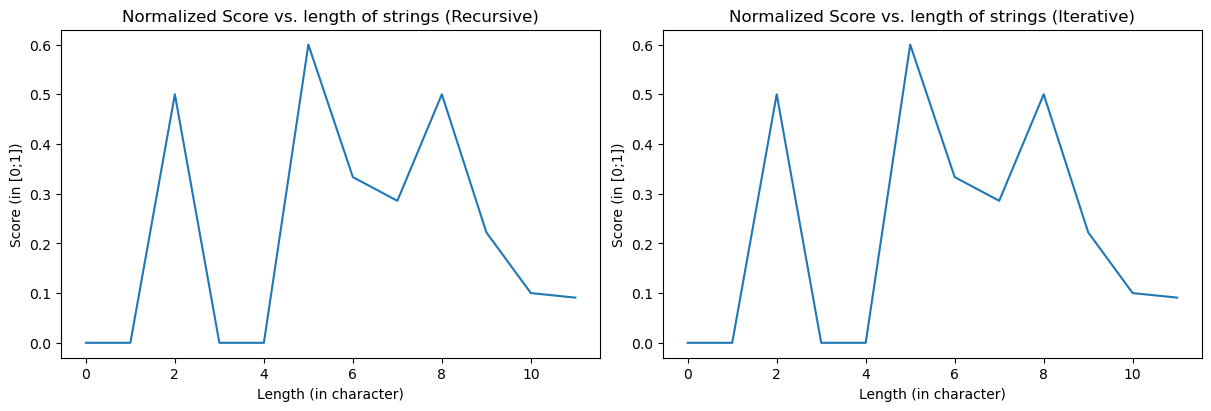

In [20]:
# Test if we get the same results with the iterative and with the recursive version
from matplotlib import pyplot as plt
import numpy as np

dist_arr_rec, dist_arr_iter = [0], [0]
length_arr = [0]
alphabet = ['a','b','c','d','e','f','g']

for i in range(1, 12):
    length = i
    # generate to sequences of i letters from alphabet
    l,v = ''.join(j for j in np.random.choice(alphabet,length)),''.join(y for y in np.random.choice(alphabet,length))

    #   recursive
    dist_arr_rec.append(normalizedRecLev(l,v))

    #   iter
    dist_arr_iter.append(iterLevenshtein(l,v))
    
    length_arr.append(i)

fig, (ax1, ax2) = plt.subplots(1, 2, constrained_layout=True, figsize=(12, 4))
ax1.plot(length_arr,dist_arr_rec)
ax2.plot(length_arr,dist_arr_iter)
ax1.set_title("Normalized Score vs. length of strings (Recursive)");  ax2.set_title("Normalized Score vs. length of strings (Iterative)")
ax1.set_ylabel('Score (in [0;1])')  ;  ax2.set_ylabel('Score (in [0;1])') 
ax1.set_xlabel('Length (in character)')   ;  ax2.set_xlabel('Length (in character)') 
plt.show()  

### Performance study

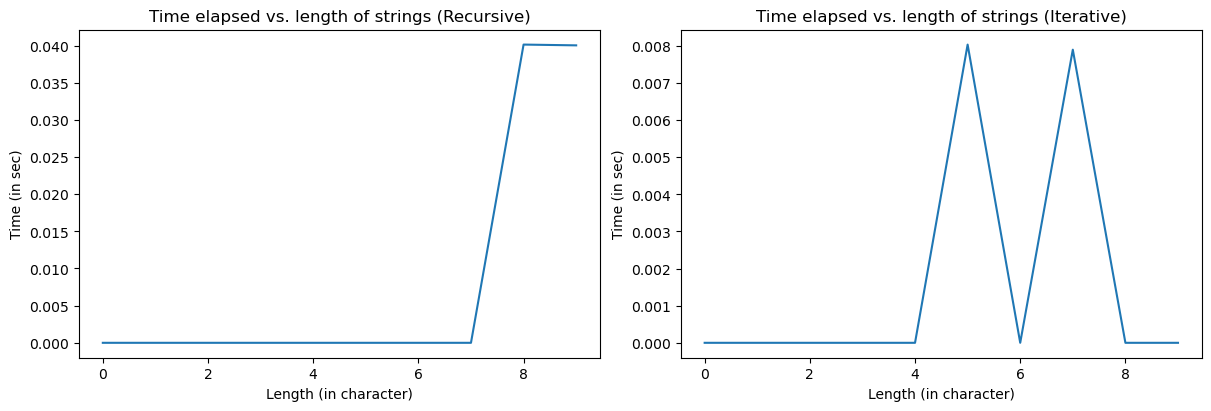

In [21]:
# Check the performance with the iterative version and with the recursive version

import time
time_arr_rec, time_arr_iter = [0], [0]
length_arr = [0]
for i in range(1, 10):
    length = i
    l,v = ''.join(j for j in np.random.choice(alphabet,length)),''.join(y for y in np.random.choice(alphabet,length))

    #   recursive
    start = time.time()
    recLevenshtein(l,v)
    time_arr_rec.append(time.time()-start)

    #   iter
    start = time.time()
    iterLevenshtein(l,v)
    time_arr_iter.append(time.time()-start)
    
    length_arr.append(i)

fig, (ax3, ax4) = plt.subplots(1, 2, constrained_layout=True, figsize=(12, 4))
ax3.plot(length_arr,time_arr_rec)
ax4.plot(length_arr,time_arr_iter)
ax3.set_title("Time elapsed vs. length of strings (Recursive)");  ax4.set_title("Time elapsed vs. length of strings (Iterative)")
ax3.set_ylabel('Time (in sec)')  ;  ax4.set_ylabel('Time (in sec)') 
ax3.set_xlabel('Length (in character)')   ;  ax4.set_xlabel('Length (in character)') 
plt.show()    


### Damerau-Levenshtein VS Levenshtein

In [22]:
# Illustrate the difference between the Levenshtein algorithm and the Damerau-Levenshtein algorithm

print('Distance between smith & smiht with the Damerau-Levenshtein algorithm: ',round(5-damerauLevenshtein("smith","smiht")*5))
print('Distance between smith & smiht with the Levenshtein algorithm: ',round(5-iterLevenshtein("smith","smiht")*5))
print('')
print('Distance between fruits & frruits with the Damerau-Levenshtein algorithm: ',round(7-damerauLevenshtein("fruits","frruits")*7))
print('Distance between fruits & frruits with the Levenshtein algorithm: ',round(7-iterLevenshtein("fruits","frruits")*7))
print('')
print('Distance between warning & hello with the Damerau-Levenshtein algorithm: ',round(7-damerauLevenshtein("warning","hello")*7))
print('Distance between warning & hello with the Levenshtein algorithm: ',round(7-iterLevenshtein("warning","hello")*7))


Distance between smith & smiht with the Damerau-Levenshtein algorithm:  1
Distance between smith & smiht with the Levenshtein algorithm:  2

Distance between fruits & frruits with the Damerau-Levenshtein algorithm:  1
Distance between fruits & frruits with the Levenshtein algorithm:  1

Distance between warning & hello with the Damerau-Levenshtein algorithm:  7
Distance between warning & hello with the Levenshtein algorithm:  7


## 3- Data Analysis 

In [23]:
damerauLev = []
iterLev = []
tab = []
for x in new_data.items():
    for y in new_data.items():
        if y not in tab and x!=y:
            damerauLev.append((x[0],y[0],round(damerauLevenshtein(x[1],y[1]),5)))
            iterLev.append((x[0],y[0],round(iterLevenshtein(x[1],y[1]),5)))
    tab.append(x)

In [24]:
iterLev

[('P102', 'P103', 0.47932),
 ('P102', 'P105', 0.67342),
 ('P102', 'P106', 0.29958),
 ('P102', 'P107', 0.57082),
 ('P103', 'P105', 0.5328),
 ('P103', 'P106', 0.52739),
 ('P103', 'P107', 0.31374),
 ('P105', 'P106', 0.35388),
 ('P105', 'P107', 0.48851),
 ('P106', 'P107', 0.19134)]

In [25]:
damerauLev

[('P102', 'P103', 0.47932),
 ('P102', 'P105', 0.67342),
 ('P102', 'P106', 0.29958),
 ('P102', 'P107', 0.57135),
 ('P103', 'P105', 0.5328),
 ('P103', 'P106', 0.52739),
 ('P103', 'P107', 0.31374),
 ('P105', 'P106', 0.35388),
 ('P105', 'P107', 0.48904),
 ('P106', 'P107', 0.19134)]

### Differences between Levenshtein results and Damerau-Levenshtein results

In [27]:
diff = [(x[0],x[1],x[2]-y[2]) for x,y in zip(damerauLev,iterLev)]   
diff

[('P102', 'P103', 0.0),
 ('P102', 'P105', 0.0),
 ('P102', 'P106', 0.0),
 ('P102', 'P107', 0.0005300000000000304),
 ('P103', 'P105', 0.0),
 ('P103', 'P106', 0.0),
 ('P103', 'P107', 0.0),
 ('P105', 'P106', 0.0),
 ('P105', 'P107', 0.0005299999999999749),
 ('P106', 'P107', 0.0)]

## First Results
As we can see: 

-The array iterLev contains the normalized score between the differents sequences using the Levenshtein algorithm.

-The array damerauLev  contains the normalized score between the differents sequences using the Damerau-Levenshtein algorithm.

-The array diff contains the difference between the normalized distance using both those algorithms

Lower the normalized score is, more the sequence are differents, thus more the scan path are differents (& so the strategies). 
.

###### In this study we can see that P102 & P105 are the two participants following the strategies which are closer